# Emotion Classification of Tweets

![ Twitter Logo](twitter.jpg)
Image by <a href="https://pixabay.com/users/geralt-9301/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3319619">Gerd Altmann</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3319619">Pixabay</a>

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect, Wrangle & Explore](#process)
* [<span style="color:#A690A4"> 3. Predict Tweet Classification](#predict)
* [<span style="color:#A690A4"> 4. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

This project focused on classifying tweets into six distinct emotion categories—sadness, joy, love, anger, fear, and surprise—using a straightforward neural network architecture. Despite experimenting with more complex models, my final solution is based on a simple yet effective design that balances performance and efficiency.

### Key Model Features
- **Architecture:**  
  - An **Embedding** layer transforms integer-encoded words into 50-dimensional dense vectors.
  - A single **Bidirectional GRU** layer (64 units) captures contextual information from both past and future tokens.
  - A **Dense** layer with softmax activation outputs the probability distribution over the six emotion classes.
- **Rationale:**  
  More complex models were explored but only resulted in a marginal accuracy improvement of approximately 0.5%, which did not justify the additional computational cost and complexity.

### Performance Metrics
- **Test Loss:** 0.1047  
- **Test Accuracy:** 93.47%

### Conclusion
The simple model delivers strong performance with a test accuracy of 93.47% and a low test loss of 0.1047. These results demonstrate that even a minimalist approach can effectively classify tweet emotions, making it a practical solution for real-world applications where computational resources and training time may be limited.

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

In this notebook, I focus on the task of classifying tweets into six emotion categories: sadness, joy, love, anger, fear, and surprise. Given the unique challenges of social media text—such as informal language, abbreviations, and emotive expressions. My goal was to develop a model that can reliably identify the underlying emotion of each tweet.

I experimented with a range of model architectures, including more complex recurrent and attention-based networks. However, my findings indicated that these more sophisticated models improved accuracy by only about 0.5% over simpler approaches. Given this marginal gain relative to the increased complexity, I opted to use a straightforward model that is both efficient and easy to interpret.

The final model I adopted is a simple yet effective architecture based on a single Bidirectional GRU layer. This model uses an Embedding layer to convert integer-encoded words into 50-dimensional dense vectors, followed by a Bidirectional GRU that processes the sequence from both directions, and concludes with a Dense layer that outputs the probability distribution over the six emotion classes using a softmax activation function.

By leveraging this minimalist approach, I achieve strong performance with lower computational cost and easier interpretability. This balance between simplicity and performance makes my solution particularly appealing for practical applications where resources and training time are limited.

# <span style="color:#5E6997">Collect, Wrangle, and Explore</span> <a class="anchor" id="process"></a>

### Import Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

### Load the dataset and display the first five rows.

In [ ]:
df = pd.read_csv('./text.csv')
# df = pd.read_csv('/kaggle/input/emotions/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


### Description of Data
<ul>
    <li><strong>text</strong> - A string feature representing the content of the Twitter message.</li>
    <li><strong>label</strong> - A classification label indicating the primary emotion, with values ranging from 0 to 5.</li>
    <ul>
        <li><strong>0</strong> - sadness</li>
        <li><strong>1</strong> - joy</li>
        <li><strong>2</strong> - love</li>
        <li><strong>3</strong> - anger</li>
        <li><strong>3</strong> - fear</li>
        <li><strong>3</strong> - surprise</li>
    </ul>
</ul>

### Check for missing, Null or duplicate values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [4]:
df.duplicated().sum()

0

Good! No duplicates or Nulls.

### Get rid of the duplicate index column.

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

### Rename existing features.

In [6]:
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)

### Copy the dataset to be used in data analysis.

In [7]:
label_df = df.copy()

### Change numerical encoding to text-based enconding. 

In [8]:
label_df['Label'] = label_df['Label'].replace(0,'Sadness')
label_df['Label'] = label_df['Label'].replace(1,'Joy')
label_df['Label'] = label_df['Label'].replace(2,'Love')
label_df['Label'] = label_df['Label'].replace(3,'Anger')
label_df['Label'] = label_df['Label'].replace(4,'Fear')
label_df['Label'] = label_df['Label'].replace(5,'Surprise')

### Distribution of the emotion labels in the dataset.

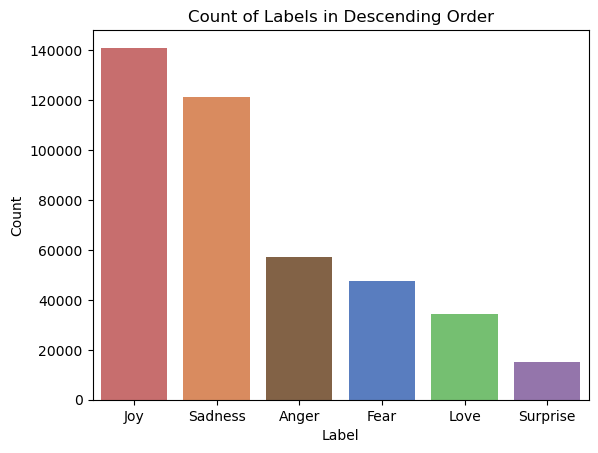

In [ ]:
# Compute descending order of labels based on count
order = label_df['Label'].value_counts().index

# Create the countplot with a vibrant 'plasma' palette.
# Here I assign 'Label' to both x and hue to satisfy the future requirements.
sns.countplot(x='Label', hue='Label', data=label_df, order=order, palette='muted')

# Remove the redundant legend since the hue is identical to x.
plt.legend([],[], frameon=False)

# Add title and labels for clarity
plt.title("Count of Labels in Descending Order")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Create seperate Dataframes for each emotional label.

In [10]:
df_sadness = label_df[label_df['Label']=='Sadness']
df_joy = label_df[label_df['Label']=='Joy']
df_love = label_df[label_df['Label']=='Love']
df_anger = label_df[label_df['Label']=='Anger']
df_fear = label_df[label_df['Label']=='Fear']
df_surprise = label_df[label_df['Label']=='Surprise']

### Combine text from different emotions. 

In [11]:
combined_all_text = ' '.join(df['Text'])
combined_sadness_text = ' '.join(df_sadness['Text'])
combined_joy_text = ' '.join(df_joy['Text'])
combined_love_text = ' '.join(df_love['Text'])
combined_anger_text = ' '.join(df_anger['Text'])
combined_fear_text = ' '.join(df_fear['Text'])
combined_surprise_text = ' '.join(df_surprise['Text'])

### I would like to see difference between the top 100 words in the all of the Tweets,  and the top 100 words in each emotional category.

In [12]:
from collections import Counter
from IPython.display import display

# Set option to display all text in each cell
pd.set_option('display.max_colwidth', None)

# First, create a dictionary of top 100 words for each category (ignoring counts)
texts = {
    "All": combined_all_text,
    "Sadness": combined_sadness_text,
    "Joy": combined_joy_text,
    "Love": combined_love_text,
    "Anger": combined_anger_text,
    "Fear": combined_fear_text,
    "Surprise": combined_surprise_text
}

top_words_dict = {}
for category, text in texts.items():
    tokens = text.split()  # simple tokenization; adjust if necessary
    counter = Counter(tokens)
    top_words = [word for word, count in counter.most_common(100)]
    top_words_dict[category] = top_words

# Build a table showing the difference between the top 50 in "All" and in each other category.
data = []
all_set = set(top_words_dict["All"])
for category, words in top_words_dict.items():
    if category == "All":
        continue
    cat_set = set(words)
    # Calculate the words unique in the category (that do not appear in "All")
    unique_in_cat = sorted(cat_set - all_set)
    data.append({
        "Category": category,
        "Unique in Category (not in All)": ", ".join(unique_in_cat)
    })

df_diff = pd.DataFrame(data)

# Display the resulting table with full cell content
display(df_diff)


,Category,Unique in Category (not in All)
0,Sadness,"back, over"
1,Joy,"good, happy, need, pretty, their, well"
2,Love,"accepted, blessed, caring, gentle, his, hot, liked, longing, loved, lovely, loving, passionate, romantic, supporting, sweet, sympathetic, tender, your"
3,Anger,"angry, annoyed, cant, cold, frustrated, off, selfish"
4,Fear,"afraid, anxious, insecure, nervous, overwhelmed, pressured, reluctant, scared, strange, terrified, uncomfortable, unsure, vulnerable, weird"
5,Surprise,"amazed, amazing, curious, dazed, feels, funny, impressed, overwhelmed, see, shocked, strange, stunned, surprised, weird"


The table above shows the words that are among the top 100 in each emotion category but do not appear in the top 100 for “All” tweets. Here's an analysis of the results:

#### Sadness
- **Unique Words:** "back, over"
- **Analysis:**  
  The uniqueness of the sadness category is minimal—only two words. This may indicate that most of the high-frequency vocabulary in sadness tweets is also common in the overall tweet collection. Alternatively, it might suggest that sadness is expressed using more generic terms that overlap with other emotions.

#### Joy
- **Unique Words:** "good, happy, need, pretty, their, well"
- **Analysis:**  
  The joy category includes clearly positive words like "good" and "happy," which are expected in joyful expressions. However, the presence of words like "need," "their," and "well" (which are more generic) suggests that the uniqueness here is modest. These words might be used in contexts of joy but are not as strongly emotion-specific as those in other categories.

#### Love
- **Unique Words:** "accepted, blessed, caring, gentle, his, hot, liked, longing, loved, lovely, loving, passionate, romantic, supporting, sweet, sympathetic, tender, your"
- **Analysis:**  
  The love category exhibits a rich vocabulary that clearly relates to affection and romance. Words like "romantic," "loving," "tender," and "passionate" are highly specific to expressions of love. This strong set of unique words helps differentiate love from the overall language of tweets.

#### Anger
- **Unique Words:** "angry, annoyed, cant, cold, frustrated, off, selfish"
- **Analysis:**  
  The anger category shows a set of words that are directly linked to expressions of irritation and hostility. Words like "angry," "annoyed," and "frustrated" are unambiguous markers of anger. The relatively short list indicates that these distinctive anger-related words are not as prevalent in the overall collection of tweets.

#### Fear
- **Unique Words:** "afraid, anxious, insecure, nervous, overwhelmed, pressured, reluctant, scared, strange, terrified, uncomfortable, unsure, vulnerable, weird"
- **Analysis:**  
  Fear is characterized by a variety of adjectives that capture apprehension and unease. Words such as "afraid," "anxious," "nervous," and "terrified" clearly signal fear. However, the inclusion of more ambiguous terms like "strange" and "weird" (which also appear in surprise) suggests there can be some overlap in how these emotions are linguistically expressed.

#### Surprise
- **Unique Words:** "amazed, amazing, curious, dazed, feels, funny, impressed, overwhelmed, see, shocked, strange, stunned, surprised, weird"
- **Analysis:**  
  For surprise, many words indicate astonishment or a sudden reaction, such as "amazed," "shocked," "stunned," and "surprised." Interestingly, words like "overwhelmed," "strange," and "weird" also appear here and in fear, suggesting that these two emotions may share some linguistic cues in certain contexts.

In summary, the analysis of the unique words reveals that while some emotion categories (like love and anger) are expressed with a rich set of distinctive terms, others (like sadness) share much of their vocabulary with the overall tweet corpus. Understanding these nuances is crucial for refining both data preprocessing and model design in emotion classification tasks.

### Create WordClouds. 

In [13]:
all_wordcloud = WordCloud(background_color='white').generate(combined_all_text)
sadness_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_sadness_text)
joy_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_joy_text)
love_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_love_text)
anger_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_anger_text)
fear_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_fear_text)
surprise_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(combined_surprise_text)

### Plot the WordClouds.

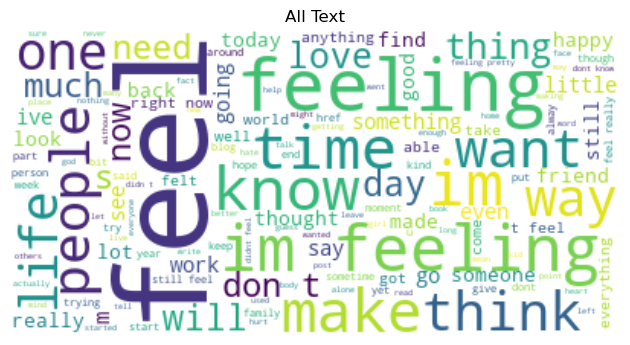

In [14]:
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.title('All Text')
plt.axis('off')

plt.tight_layout()
# plt.savefig("alltext.jpg", dpi=300)
plt.show()


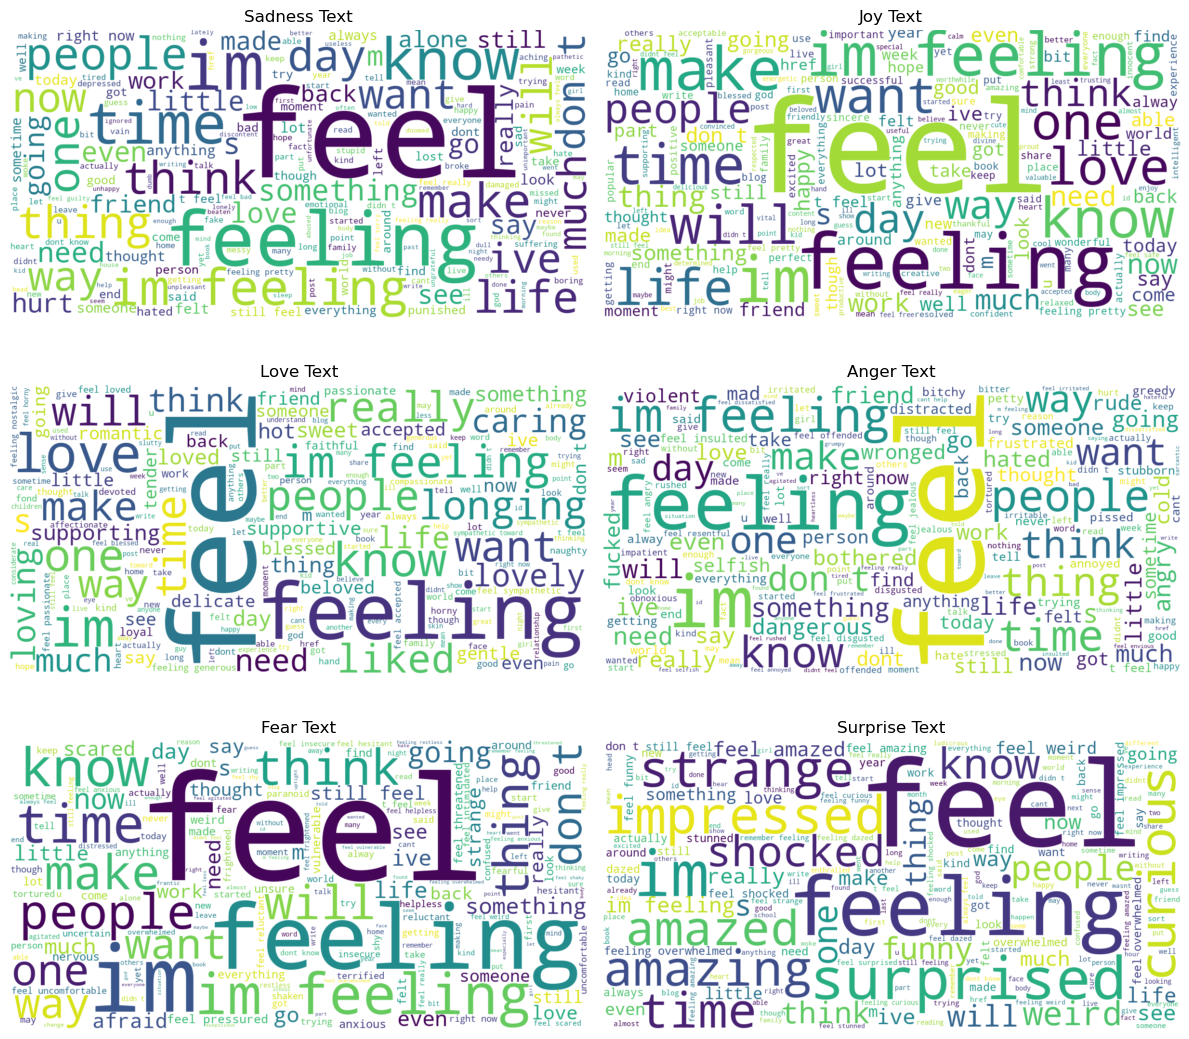

In [15]:
plt.figure(figsize=(12, 11))  # Adjust the figure size as needed

plt.subplot(3, 2, 1)
plt.imshow(sadness_wordcloud, interpolation='bilinear')
plt.title('Sadness Text')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Text')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(love_wordcloud, interpolation='bilinear')
plt.title('Love Text')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Text')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Text')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(surprise_wordcloud, interpolation='bilinear')
plt.title('Surprise Text')
plt.axis('off')

plt.tight_layout()
plt.show()


### Text Preprocessing

Import needed libraries. Download the necessary stopwords for use in text processing. After running it, I can filter out common stopwords from the text data.

In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnpospisil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove URLs.

In [17]:
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)

Remove puctuation.

In [18]:
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

Remove extra whitespaces.

In [19]:
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

Remove Numeric Values in Text.

In [20]:
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

Lowercase all text.

In [21]:
df['Text'] = df['Text'].str.lower()

Remove Stopwords.

In [22]:
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Remove all non-alphabetic characters.

In [23]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

### Create the Train/Test Split

In [24]:
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Tokenization and Padding Sequences

This code takes your text data, builds a vocabulary (limiting it to the most frequent 50,000 words), and then converts the texts into sequences of integers that can be used as input for a machine learning model.

In [25]:
tokenizer = Tokenizer(num_words=50000)
# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
# Transforms each text in texts to a sequence of integers.
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

Find the Maximum Length in X_train_sequences.

In [26]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
maxlen

79

This code standardizes the length of all the sequences by padding them to the length of the longest training sequence.

In [27]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

# <span style="color:#5E6997">Predict Tweet Classification</span> <a class="anchor" id="predict"></a>

### Define Input Size.

In [28]:
input_Size = np.max(X_train_padded) + 1
input_Size

50000

### The Model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

# Define key parameters
input_Size = input_Size      # Size of your vocabulary
embedding_dim = 50      # Dimensionality of the embedding vectors
num_labels = 6          # Number of emotion classes

# Build a simple base model using the Sequential API
base_model = Sequential([
    # Embedding layer to convert tokens into dense vectors
    Embedding(input_dim=input_Size, output_dim=embedding_dim),
    
    # A single Bidirectional GRU layer to process the sequence in both directions.
    Bidirectional(GRU(64)),
    
    # Output Dense layer with softmax activation for classification
    Dense(num_labels, activation='softmax')
])

# Compile the base model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the base model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          2500000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              44544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 2,545,318
Trainable params: 2,545,318
Non-trainable params: 0
_________________________________________________________________


2025-03-06 09:38:11.229477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-06 09:38:11.230542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-06 09:38:11.231311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
history = base_model.fit(X_train_padded, y_train, epochs=4, batch_size=256, validation_data=(X_test_padded, y_test))

Epoch 1/4


2025-03-06 09:38:11.387835: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-06 09:38:11.533903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-06 09:38:11.535006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-06 09:38:11.535809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

1303/1303 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8749

2025-03-06 09:41:08.600384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-06 09:41:08.601426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-06 09:41:08.602189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1303/1303 [==============================] - 188s 143ms/step - loss: 0.3053 - accuracy: 0.8749 - val_loss: 0.1086 - val_accuracy: 0.9349
Epoch 2/4
1303/1303 [==============================] - 192s 147ms/step - loss: 0.0985 - accuracy: 0.9389 - val_loss: 0.1033 - val_accuracy: 0.9344
Epoch 3/4
1303/1303 [==============================] - 192s 147ms/step - loss: 0.0906 - accuracy: 0.9415 - val_loss: 0.1025 - val_accuracy: 0.9318
Epoch 4/4
1303/1303 [==============================] - 200s 153ms/step - loss: 0.0875 - accuracy: 0.9422 - val_loss: 0.1047 - val_accuracy: 0.9347


In [31]:
base_model.evaluate(X_test_padded, y_test)

2606/2606 [==============================] - 16s 6ms/step - loss: 0.1047 - accuracy: 0.9347


[0.10469459742307663, 0.9346704483032227]

### Visualize Results

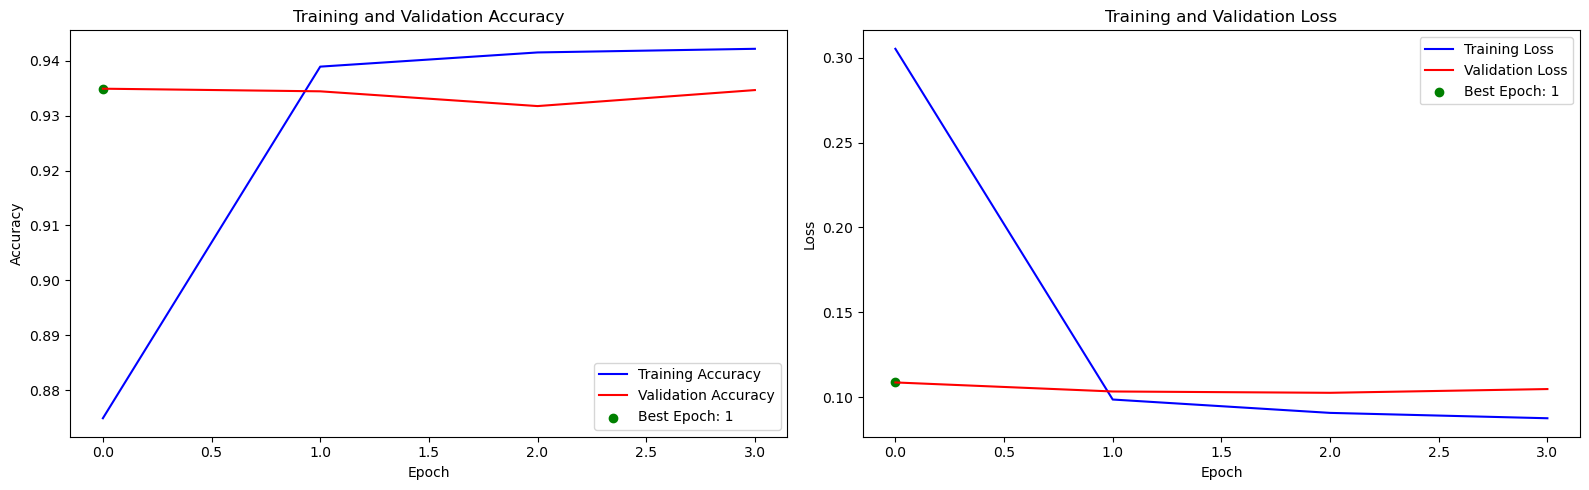

In [ ]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
plt.tight_layout()
# plt.savefig("Train_and_Val_accuracy.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix
y_pred = base_model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2025-03-06 09:51:19.703496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-06 09:51:19.704608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-06 09:51:19.705500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2606/2606 [==============================] - 17s 7ms/step


### The Confusion Matrix

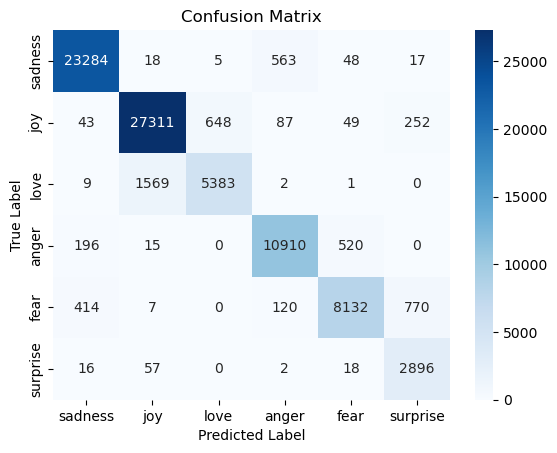

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Define class labels
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create the heatmap with custom tick labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig("matrix.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

#### 1. Sadness 
- **Correctly predicted as sadness:** 23,284  
- **Most common misclassification:** Predicted as anger (563), and to a lesser extent fear (48).  
- **Interpretation:** The model does a good job recognizing sadness, but it sometimes confuses sadness with anger (both can be negatively valenced emotions).

#### 2. Joy
- **Correctly predicted as joy:** 27,311  
- **Most common misclassification:** Predicted as love (648), and some predicted as surprise (252).  
- **Interpretation:** Joy and love are both positive emotions, so the confusion is somewhat expected. The model largely distinguishes joy well.

#### 3. Love
- **Correctly predicted as love:** 5,383  
- **Most common misclassification:** Predicted as joy (1,569).  
- **Interpretation:** The model struggles more here, frequently mixing love with joy. Again, these are closely related positive emotions, so confusion can occur.

#### 4. Anger
- **Correctly predicted as anger:** 10,910  
- **Most common misclassification:** Predicted as fear (520) and sadness (196).  
- **Interpretation:** Anger is usually recognized correctly, but there’s some mix-up with other negative emotions like fear and sadness.

#### 5. Fear
- **Correctly predicted as fear:** 8,132  
- **Most common misclassification:** Predicted as sadness (414), surprise (770), and anger (120).  
- **Interpretation:** Fear gets confused with sadness and surprise—possibly because fear and sadness are both negative, while fear and surprise can share a sense of heightened arousal.

#### 6. Surprise
- **Correctly predicted as surprise:** 2,896  
- **Most common misclassification:** Predicted as joy (57), sadness (16), and fear (18).  
- **Interpretation:** Surprise is relatively well-recognized, but the model sometimes mistakes it for other emotions that can have overlapping expressions (especially fear).


In short, the model is strongest at recognizing **sadness** and **joy**, but confuses closely related emotions (like **love** ↔ **joy** and **fear** ↔ **surprise**). Addressing class imbalances and refining the model architecture or training strategy could help reduce these misclassifications.

# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>

This project focused on classifying tweets into six distinct emotions: sadness, joy, love, anger, fear, and surprise. Below is a summary of the key observations and results:

### 🤔 Overall Findings
- The confusion matrix shows strong performance on sadness (23,284 correct) and joy (27,311 correct), with occasional misclassifications among closely related emotions (e.g., joy vs. love, anger vs. fear).  
- The training and validation curves indicate rapid convergence by the first epoch, followed by relatively stable performance in subsequent epochs.

### 📊 Key Results
- Final test set evaluation yielded a loss of **0.1047** and an accuracy of **0.9347**, reflecting solid generalization.  
- Sadness and joy were most accurately classified, whereas love and fear showed moderate confusion with other similarly valenced emotions.  
- Early stopping or additional regularization could be beneficial, given the best epoch appears to occur early in training.

### 🚀 Potential Improvements
- Experiment with advanced architectures (e.g., transformers) or pre-trained embeddings (e.g., GloVe, fastText) to capture more nuanced language patterns.  
- Collect additional data or apply class-balancing strategies if certain emotions (like love or surprise) are underrepresented.  
- Fine-tune hyperparameters (learning rate, batch size, dropout rates) and consider adding attention mechanisms for more granular control over sequence context.  

Overall, the model demonstrates strong performance in classifying tweets by emotion, with room for further enhancements to address misclassifications among similar emotional categories.